In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import trimesh

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = jnp.array(vertices, dtype=jnp.float32)  # Shape: (V, 3)
        self.faces = jnp.array(faces, dtype=jnp.int32)          # Shape: (F, 3)

@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    epsilon = 1e-6
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = 1.0 / a
    s = p0 - v0
    u = f * jnp.dot(s, h)
    valid_u = (u >= 0.0) & (u <= 1.0)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    valid_v = (v >= 0.0) & (u + v <= 1.0)
    t = f * jnp.dot(e2, q)
    valid_t = t > epsilon
    intersects = (~parallel) & valid_u & valid_v & valid_t
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])  # Arbitrary direction
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    
    intersects = jax.vmap(
        ray_intersects_triangle, in_axes=(None, None, 0, 0, 0)
    )(point, ray_direction, v0, v1, v2)
    num_intersections = jnp.sum(intersects)
    return num_intersections % 2 == 1  # Inside if odd number of intersections

def min_max_coord(vertices):
    min_coords = jnp.min(vertices, axis=0)
    max_coords = jnp.max(vertices, axis=0)
    return min_coords, max_coords

@partial(jax.jit, static_argnames=['num_samples'])
def monte_carlo_intersection_volume(
    mesh1_vertices, mesh1_faces, mesh2_vertices, mesh2_faces, num_samples, key
):
    min_coords1, max_coords1 = min_max_coord(mesh1_vertices)
    min_coords2, max_coords2 = min_max_coord(mesh2_vertices)
    
    min_coords = jnp.maximum(min_coords1, min_coords2)
    max_coords = jnp.minimum(max_coords1, max_coords2)
    
    overlap = jnp.all(min_coords < max_coords)
    bbox_volume = jnp.prod(max_coords - min_coords)
    
    def sample_points(key):
        subkey_x, subkey_y, subkey_z = jax.random.split(key, 3)
        x = jax.random.uniform(subkey_x, shape=(num_samples,), minval=min_coords[0], maxval=max_coords[0])
        y = jax.random.uniform(subkey_y, shape=(num_samples,), minval=min_coords[1], maxval=max_coords[1])
        z = jax.random.uniform(subkey_z, shape=(num_samples,), minval=min_coords[2], maxval=max_coords[2])
        points = jnp.stack([x, y, z], axis=1)
        return points
    
    points = sample_points(key)
    
    point_in_mesh_vmap = jax.vmap(point_in_mesh, in_axes=(0, None, None))
    
    in_mesh1 = point_in_mesh_vmap(points, mesh1_vertices, mesh1_faces)
    in_mesh2 = point_in_mesh_vmap(points, mesh2_vertices, mesh2_faces)
    in_both_meshes = in_mesh1 & in_mesh2
    
    hits = jnp.sum(in_both_meshes)
    intersection_volume = (hits / num_samples) * bbox_volume * overlap
    return intersection_volume



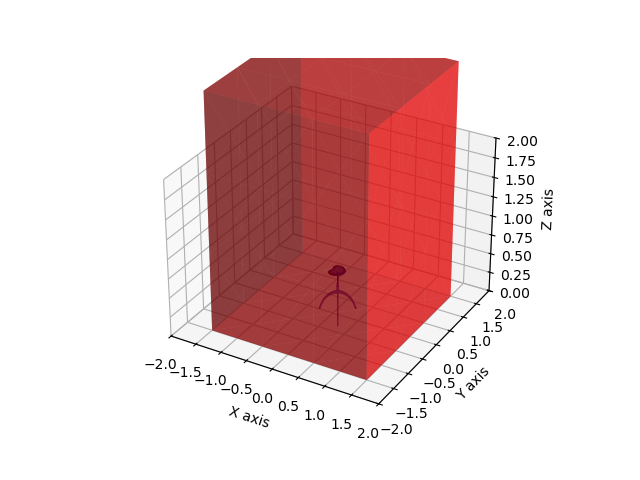

In [2]:
%matplotlib widget
# Plot the two meshes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mesh1 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/07_01_001.obj')
ax.plot_trisurf(mesh1.vertices[:, 0], mesh1.vertices[:,2], mesh1.vertices[:,1], triangles=mesh1.faces, 
                    color='b', alpha=0.5)
 
mesh2 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/cube.obj')
# mesh2.vertices[:, 0] *= 2
# mesh2.vertices[:, 2] *= 2
mesh2.vertices *= 3
ax.plot_trisurf(mesh2.vertices[:, 0], mesh2.vertices[:,2], mesh2.vertices[:,1], triangles=mesh2.faces, 
                    color='r', alpha=0.5)

# Set plot limits and labels
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(0, 2)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [3]:
num_samples = 10000  # Adjust for desired accuracy
key = jax.random.PRNGKey(0)  # Random seed

intersection_volume = monte_carlo_intersection_volume(
    mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces, num_samples, key
)
print("Intersection Volume (Monte Carlo with JAX):", intersection_volume)


Intersection Volume (Monte Carlo with JAX): 0.0023076383


In [4]:
mesh1.volume

0.002565914886490454